# Validation of ESG module

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from source.noise import NoiseGenerator
from source.esg import EconomicScenarioGenerator

In [8]:
N = 100000
interval = 12
T = 5
steps = interval * T

### Simulation parameters

In [9]:
with open('./data/params.pkl', 'rb') as f:
     s0, Corr, variance, mean, ar = pickle.load(f)

In [10]:
s0

AK_SV            224.480000
AK_WORLD        4041.233665
AK_WORLD_LOC     591.744572
ALTERNATIVA      100.000000
CPI              278.000000
FASTIGHETER      100.400000
KRED_SV          196.460000
RB_UTL           329.810800
RB_SV_1_RATE       0.029400
RB_SV_5            0.039880
RB_SV_15           0.048920
SPREAD             0.003790
Name: 2003-12-31, dtype: float64

### Pick index of a stock and a rate

In [11]:
Si = np.where(s0.index == 'AK_SV')[0][0]
ri = np.where(s0.index == 'RB_SV_1_RATE')[0][0]

In [12]:
S0 = s0.to_numpy()[[Si, ri]]
a = ar.to_numpy()[[Si, ri]]
mu = mean.to_numpy()[[Si, ri]]
sigma = np.sqrt(variance.to_numpy()[[Si, ri]])
corrmatrix = Corr.to_numpy()[np.ix_([Si,ri],[Si,ri])]

## Simulate

In [13]:
NG = NoiseGenerator()
dB = NG.brown_steps(corrmatrix, N * steps)

In [14]:
dB.shape

(2, 6000000)

In [15]:
ESG = EconomicScenarioGenerator(S0, a, mu, sigma, dB)
AK, RB = ESG.get_scenarios(N, steps, interval)

### Stocks

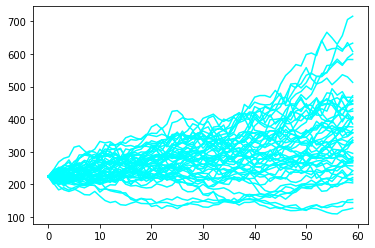

In [16]:
for s in AK[:50]:
    plt.plot(s.T, color='cyan')

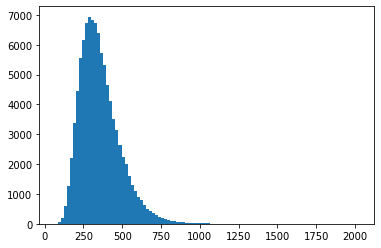

In [17]:
counts, bins = np.histogram(AK[:,:,-1], bins=100)
plt.hist(bins[:-1], bins, weights=counts);

Log-normal

### Values in 1% quantiles

In [18]:
[bins[1],bins[99]]

[83.6414509299222, 2005.8848790153836]

### Rates

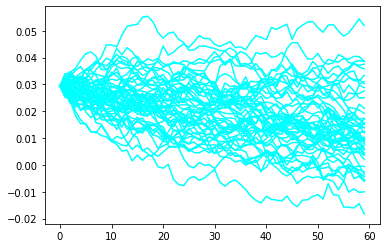

In [19]:
for r in RB[:50]:
    plt.plot(r.T, color='cyan')

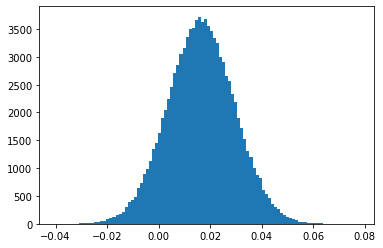

In [20]:
counts, bins = np.histogram(RB[:,:,-1], bins=100)
plt.hist(bins[:-1], bins, weights=counts);

Normal

## Validate

In [30]:
sim_stock_returns = np.diff(np.log(np.squeeze(AK)))
#sim_stock_returns = np.diff(np.squeeze(AK))
sim_rate_returns = np.diff(np.squeeze(RB))

### Correlation

In [31]:
np.corrcoef(sim_stock_returns.flatten(), sim_rate_returns.flatten())

array([[1.        , 0.20266849],
       [0.20266849, 1.        ]])

In [32]:
corrmatrix

array([[1.       , 0.2028056],
       [0.2028056, 1.       ]])

### Variance

In [33]:
np.cov(sim_stock_returns.flatten(), sim_rate_returns.flatten()) * interval

array([[2.54768358e-02, 2.30702244e-04],
       [2.30702244e-04, 5.08610928e-05]])

In [34]:
sigma**2

array([2.57727660e-02, 5.07720393e-05])

### Mean

In [35]:
np.mean(sim_stock_returns.flatten()) * interval, np.mean(sim_rate_returns.flatten()) * interval

(0.0812071386799835, -0.0026331926090880377)

In [36]:
mu

array([ 0.0942865 , -0.00646125])